In [10]:
import pandas as pd
import spacy, copy
from queue import *
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
nlp = spacy.load('pt')
#nodes = pd.read_csv('data/Networks/MilkO/nodes.csv')
#edges = pd.read_csv('data/Networks/MilkO/edges.csv')

merged = pd.read_csv('data/Networks/Merged/Merged.csv', sep=';')
milko = pd.read_csv('data/Networks/MilkO/MilkOFinal.csv', sep=';')
wikipedia = pd.read_csv('data/Networks/Wikipedia/wikipediaTerms.csv', sep=',')
fullymerged = pd.read_csv('data/Networks/MergedWithQuestionTerms/FullyMerged.csv', sep=',')
fullymergedLemma = pd.read_csv('data/Networks/MergedWithQuestionTerms/FullyMergedLemmatized.csv')
finalWithWh = pd.read_csv('data/Networks/MergedWithQuestionTerms/FinalWithWHWords.csv')
#listOfNetworks = {"Merged": merged, "Milko": milko, "Wikipedia": wikipedia, "FullyMerged": fullymerged, "FullyMergedLemmatized": fullymergedLemma}
listOfNetworks = {"FinalWithWHWords": finalWithWh}
respostas = pd.read_csv('data/Raw/quinhentas_respostas.csv')
perguntas = pd.read_csv('data/Raw/quinhentas_perguntas.csv')

In [2]:
import textacy
import textacy.keyterms
from tools import getRoot
from multiprocessing import Pool
from IPython.display import clear_output


pt = textacy.load_spacy('pt', disable=('parser',))

topics = [40, 134, 289, 339, 379, 414, 449, 457, 468, 482, 500]
currentTopic = 1
currentMax = 40
topicText = {1:"",2:"",3:"",4:"",5:"",6:"",7:"",8:"",9:"",10:"",11:""}

for idx, row in respostas.iterrows():
    text = ""
    words = [x.strip() for x in row['resposta'].split(' ') if x.strip() !=""]
    #for word in words:
        #w = getRoot(word)
        #text+= " "+w
    with Pool(min(20, len(words))) as pool:
        results = pool.map(getRoot, words)
        text = (" ").join(results)
    if idx < currentMax:
        topicText[currentTopic]+=text
    else:
        currentMax=topics[currentTopic]
        currentTopic+=1
    clear_output()
    print((idx/500)*100,"%", "Current Topic:", currentTopic)
    
        
#mydoc = textacy.Doc((" ").join(alltext), lang = pt)
#bot = mydoc.to_bag_of_terms(ngrams=(1, 2, 3), named_entities=True, weighting='count', as_strings=True)
#print(bot)
            
            




99.8 % Current Topic: 11


In [6]:
import pickle
with open('data/SupportingStructures/topictext.pickle', 'wb') as handle:
            pickle.dump(topicText, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Topictext pickled sucessfully.")

Topictext pickled sucessfully.


In [7]:
import pickle
import pandas as pd
pickle_in = open('data/SupportingStructures/topictext.pickle', 'rb')
topics = pickle.load(pickle_in)
graph = loadNetwork(finalWithWh)
for topic in topics:
    graph = addDocument(graph, topic, topics[topic], True, True)
    

In [25]:
from IPython.display import clear_output
results = pd.DataFrame(columns=['Network','DecayRate','PreciseHits','Pct Hits', 'Window', 'HitsInWindow', 'PctHitsInWindow'])
topics = [40, 134, 289, 339, 379, 414, 449, 457, 468, 482, 500]
for decay in [0.1, 0.2, 0.3]:
    print("Working on ", decay, "decay rate.")
    hits = 0
    currentTopic = 1
    currentMax = 40
    for idx, row in perguntas.iterrows():
        clear_output()
        print((idx/500)*100,"%", "Current Decay:", decay)
        grp = copy.deepcopy(graph)
        print('Expected:', currentTopic, 'Got:', getMostRanked(graph, perguntas.iloc[idx]['pergunta'])[0][0])
        hits += isHit(grp, row['pergunta'], currentTopic, audit=False, decay = decay)
        if idx > currentMax:
            currentMax=topics[currentTopic]
            currentTopic+=1
    results = results.append({"Network":'TopicTest', "DecayRate":decay, "PreciseHits":hits, "Pct Hits":hits/500, "Window":'N/A', "HitsInWindow":'N/A', "PctHitsInWindow":'N/A'}, ignore_index=True)
print("Tests done.")

99.8 % Current Decay: 0.3
Expected: 11 Got: 8
Tests done.


In [20]:
cp

,Network,DecayRate,PreciseHits,Pct Hits,Window,HitsInWindow,PctHitsInWindow
0,TopicTest,0.2,225,0.45,N/A,N/A,N/A


In [27]:
results.to_csv('data/Networks/TopicTestResults.csv')

In [3]:
import pandas as pd
def loadNetwork(network_dataframe):
    graph = dict()
    for index, edge in network_dataframe.iterrows():
        if not(edge['from'] in graph):
            graph[edge['from']]={'weight':0, 'documents':dict(), 'edges':[]}
        if not(edge['to'] in graph):
            graph[edge['to']]={'weight':0, 'documents':dict(), 'edges':[]}
        graph[edge['from']]['edges'].append({'term':edge['to'],'weight':0})
    return graph

def getTermDictionary(graph):
    dictionary = set()
    for edge in graph:
        dictionary.add(edge)
    return dictionary

In [4]:
import spacy
nlp = spacy.load('pt')

def addDocument(graph, document_id, document_text, normalized = False, allowRepetitions = True, useTFIDF = True):
    termsInDocument = listOfWords(graph, document_text)
    if allowRepetitions == False:
        termsInDocument = set(termsInDocument)
    toAdd = 1
    if normalized == True:
        toAdd = 1 /len(termsInDocument) if len(termsInDocument) > 0 else 1
    for term in termsInDocument:
        if document_id in graph[term]['documents']:
            graph[term]['documents'][document_id] +=toAdd
        else:
            graph[term]['documents'][document_id] = toAdd
        
    return graph

def getMostRanked(graph, input_string, listsize = 10, decay = 0.5):
    grp = copy.deepcopy(graph)
    grp = activeGraph(processSent(grp, input_string, decay))
    docvalues = dict()
    for entry in grp:
        for doc in grp[entry]['documents']:
            if doc in docvalues:
                docvalues[doc] = grp[entry]['weight']*grp[entry]['documents'][doc]+docvalues[doc]
            else:
                docvalues[doc] = grp[entry]['weight']*grp[entry]['documents'][doc]
    return sorted(docvalues.items(), key=lambda kv: kv[1], reverse=True)[:listsize]

def isHit(graph, input_string, correctanswer, listsize = 10, audit = False, decay = 0.5):
    retrievedAnswers = getMostRanked(graph, input_string, listsize, decay = decay)
    s = slice(0, listsize)
    topn = [answer[0] for answer in retrievedAnswers]
    topn = topn[s]
    if audit == True:
        print(topn, correctanswer)
    #If the size is zero, nothing was found - have to deal with this
    if len(topn) > 0 and (topn[0] == correctanswer):
        return True;
    else:
        return False;
    
def isCorrectAnswerInWindow(graph, input_string, correctanswer, listsize = 10, decay = 0.5):
    retrievedAnswers = getMostRanked(graph, input_string, listsize, decay = decay)
    s = slice(0, listsize)
    topn = [answer[0] for answer in retrievedAnswers]
    topn = topn[s]
    if correctanswer in topn:
        return True;
    else:
        return False;


In [6]:
from dicio import Dicio
from multiprocessing import Pool
import spacy, textacy
import json, logging, multiprocessing
from tools import dicioDef

#These are going to be made into constructor arguments/inits
with open('data/SupportingStructures/completedict.json', 'r') as file:
        dicioDict = json.load(file)

        


def processSent(graph, textEntry, decay = 0.5, dicioDict = None):
    mpl = multiprocessing.log_to_stderr()
    mpl.setLevel(logging.ERROR)
    #tokenized = [lemmatizer(token.orth_, token.pos_)[0] for token in nlp(textEntry) if not (token.is_stop or token.is_punct or not token.is_alpha)]
    traversedList = set()
    words = listOfWords(graph, textEntry)
    for word in words:
        graph[word]['weight']=1
        graph, traversedList = spread(word, graph, traversedList, previousScore=1, decay=decay)
    return graph

def spread(word, graph, traversedList, previousScore=1, weight=1, decay=0.5,treshold=0.1):
    if graph[word]['weight']==0:
        graph[word]['weight']=previousScore
    futureTraversals = Queue()
    if (previousScore > treshold):
        for i in range(1, len(graph[word]['edges'])-1):
            if graph[word]['edges'][i].get('weight')==0:
                graph[word]['edges'][i].update({'weight':previousScore})
            graph[word]['edges'][i].update({'weight':graph[word]['edges'][i].get('weight')*decay})
            if graph[word]['edges'][i]['term'] not in traversedList:
                futureTraversals.put({'term':graph[word]['edges'][i].get('term'), 'weight':graph[word]['edges'][i].get('weight')})
                traversedList.add(graph[word]['edges'][i].get('term'))
        if(not futureTraversals.empty()):
            while not futureTraversals.empty():
                totraverse = futureTraversals.get()
                graph, traversedList = spread(word=totraverse['term'], graph=graph, traversedList=traversedList, previousScore=totraverse['weight'])

    else:
        return graph, traversedList
    return graph, traversedList

def activeGraph(graph):
    gcopy = copy.deepcopy(graph)
    itemsToPop = []
    for val in gcopy:
        if gcopy[val]['weight']==0:
            itemsToPop.append(val)
        else:
            gcopy[val]['edges'] = [w for w in gcopy[val]['edges'] if w.get('weight') !=0]
    for item in itemsToPop:
        del gcopy[item]
    return gcopy
'''
def dicioDef(token):
    word = token[0].lower()
    pos = token[1]
    if not (dicioDict is None):
        if word in dicioDict:
            dicioDict[word]['word']=word
            return dicioDict[word]
    dicio = Dicio()
    d = dict()
    if(pos == ""):
        w = dicio.search(word)
    else:
        w = dicio.search(word, pos)
    if not(w is None):
        d['word']=word
        d['root']=w.root
        if(d['root'] == ""):
            d['root'] = word
        d['pos']=w.pos
        d['synonyms']= [s.word for s in w.synonyms]
    else:
        d['word'] = word
        d['root'] = word
        d['pos'] = ['NOUN']
        d['synonyms'] = []
    return d
'''


def listOfWords(graph, textEntry, useTFIDF = True):
    tokens = [w for w in nlp(textEntry) if not (w.is_punct or not w.is_alpha)]
    terms = []
    with Pool(min(len(tokens), 50)) as pool:
        results = pool.map_async(dicioDef, ((token.orth_, token.pos) for token in tokens))
        terms = results.get()
    words = []
    for term in terms:
        if term['word'] in graph:
            words.append(term['word'])
        if term['root'] in graph and term['root']!=term['word']:
            words.append(term['root'])
        else:
            for syn in term['synonyms']:
                if syn in graph:
                    words.append(syn)
    return words

def activeGraphNoDocuments(graph):
    gcopy = activeGraph(graph)
    for val in gcopy:
        del gcopy[val]['documents']
    return gcopy


        


In [5]:
import logging
def performTest(networkname, filedir, decayRates = [0.2, 0.3, 0.4, 0.5], windowSizes=[10, 15, 20]):
    mpl = multiprocessing.log_to_stderr()
    mpl.setLevel(logging.INFO)
    perguntas = pd.read_csv('data/Raw/quinhentas_perguntas.csv')
    innerDf = pd.DataFrame(columns=['Network','DecayRate','PreciseHits','Pct Hits', 'Window', 'HitsInWindow', 'PctHitsInWindow'])
    pickle_in = open(filedir+networkname,"rb")
    graph = pickle.load(pickle_in)
    dictionary = getTermDictionary(graph)
    print("Started tests with", networkname[:-7])
    for decay in decayRates:
        print("Working on ", decay, "decay rate.")
        for windowSize in windowSizes:
            print("Window size:", windowSize)
            hits = 0
            recall = 0
            for idx, row in perguntas.iterrows():
                grp = copy.deepcopy(graph)
                hits += isHit(grp, dictionary, row['pergunta'], idx+1, audit=False, decay = decay)
                recall += isCorrectAnswerInWindow(grp, dictionary, row['pergunta'], idx+1, listsize = windowSize, decay = decay)
            innerDf = innerDf.append({"Network":networkname[:-7], "DecayRate":decay, "PreciseHits":hits, "Pct Hits":hits/500, "Window":windowSize, "HitsInWindow":recall, "PctHitsInWindow":recall/500}, ignore_index=True)
    print("Tests in ", networkname[:-7], "done.")
    return innerDf

In [45]:
from os import listdir
from os.path import isfile, join
import pandas as pd
perguntas = pd.read_csv('data/Raw/quinhentas_perguntas.csv')
filedir = 'data/Networks/Pickled/'
#pickledNetworks = [f for f in listdir(filedir) if isfile(join(filedir, f))]
pickledNetworks = ['FinalWithWHWordsWithDicio2NR.pickle']
results = pd.DataFrame(columns=['Network','DecayRate','PreciseHits','Pct Hits', 'Window', 'HitsInWindow', 'PctHitsInWindow'])
for network in pickledNetworks:
    pickle_in = open(filedir+network,"rb")
    graph = pickle.load(pickle_in)
    dictionary = getTermDictionary(graph)
    print("Started tests with", network[:-7])
    for decay in [0.1, 0.2, 0.3, 0.4, 0.5]:
        print("Working on ", decay, "decay rate.")
        for windowSize in [20]:
            print("Window size:", windowSize)
            hits = 0
            recall = 0
            for idx, row in perguntas.iterrows():
                grp = copy.deepcopy(graph)
                hits += isHit(grp, row['pergunta'], idx+1, audit=False, decay = decay)
                recall += isCorrectAnswerInWindow(grp, row['pergunta'], idx+1, listsize = windowSize, decay = decay)
            results = results.append({"Network":network[:-7], "DecayRate":decay, "PreciseHits":hits, "Pct Hits":hits/500, "Window":windowSize, "HitsInWindow":recall, "PctHitsInWindow":recall/500}, ignore_index=True)
    print("Tests in ", network[:-7], "done.")

Started tests with FinalWithWHWordsWithDicio2NR
Working on  0.1 decay rate.
Window size: 20
Working on  0.2 decay rate.
Window size: 20
Working on  0.3 decay rate.
Window size: 20
Working on  0.4 decay rate.
Window size: 20
Working on  0.5 decay rate.
Window size: 20
Tests in  FinalWithWHWordsWithDicio2NR done.


In [46]:
results

,Network,DecayRate,PreciseHits,Pct Hits,Window,HitsInWindow,PctHitsInWindow
0,FinalWithWHWordsWithDicio2NR,0.1,46,0.092,20,208,0.416
1,FinalWithWHWordsWithDicio2NR,0.2,46,0.092,20,204,0.408
2,FinalWithWHWordsWithDicio2NR,0.3,47,0.094,20,208,0.416
3,FinalWithWHWordsWithDicio2NR,0.4,44,0.088,20,207,0.414
4,FinalWithWHWordsWithDicio2NR,0.5,42,0.084,20,198,0.396


In [37]:
from multiprocessing import Manager, Pool
import pickle
from os import listdir
from os.path import isfile, join
filedir = 'data/Networks/Pickled/'
#totest = [f for f in listdir(filedir) if isfile(join(filedir, f))]
totest = ['FullyMergedLemmatizedWithDicio.pickle', 'FullyMergedLemmatizedWithDicioNR.pickle']
pool = Pool(processes=2)
results = [pool.apply_async(performTest, args=(network, 'data/Networks/Pickled/', [0.2], [20])) for network in totest]


[INFO/ForkPoolWorker-293] child process calling self.run()
[INFO/ForkPoolWorker-293] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-293] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-293] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-294] child process calling self.run()
[INFO/ForkPoolWorker-293] child process calling self.run

In [47]:
results.to_csv('data/Networks/ResultsWithDicioUpdatedAnd1Decay.csv')

In [9]:
from IPython.display import clear_output
import pickle
import os.path
for network in listOfNetworks:
    graph = loadNetwork(listOfNetworks[network])
    for options in [1]:
        filepath = 'data/Networks/Pickled/'
        filename = network+"WithDicio2"
        if options == 1:
            normalized = True
            allowrepetitions = True
            filename = filename +"NR"
        '''if options == 2:
            normalized = False
            allowrepetitions = True
            filename = filename +"R"
        if options == 3:
            normalized = True
            allowrepetitions = False
            filename = filename +"N"
        if options == 4:
            normalized = False
            allowrepetitions = False
        '''
        filepath = filepath+filename+'.pickle'
        if os.path.isfile(filepath):
            continue
        for idx, row in respostas.iterrows():
            clear_output()
            print((idx/500)*100,"%")
            graph = addDocument(graph, row['index'], row['resposta'], normalized, allowrepetitions)
        with open(filepath, 'wb') as handle:
            pickle.dump(graph, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(filename, "pickled sucessfully.")

    

99.8 %
FinalWithWHWordsWithDicio2NR pickled sucessfully.


In [55]:
g2 = copy.deepcopy(graph)
g2 = processSent(g2,"""Olá, gostaria de saber a diferença entre: vacas secas, vacas solteiras e vacas amojando. Agradeço desde já!""")
#print(activeGraph(g2))


{'cavalo': {'weight': 0.5, 'documents': set(), 'edges': [{'term': 'raça', 'weight': 0.25}, {'term': 'brasil', 'weight': 0.25}, {'term': 'transporte', 'weight': 0.25}, {'term': 'agricultura', 'weight': 0.25}, {'term': 'animal', 'weight': 0.25}, {'term': 'espécie', 'weight': 0.25}]}, 'vermis': {'weight': 0.0625, 'documents': set(), 'edges': []}, 'declive': {'weight': 0.0625, 'documents': set(), 'edges': []}, 'substância': {'weight': 0.0625, 'documents': set(), 'edges': [{'term': 'mistura', 'weight': 0}, {'term': 'leite', 'weight': 0}, {'term': 'água', 'weight': 0}]}, 'química': {'weight': 0.125, 'documents': set(), 'edges': [{'term': 'ureia', 'weight': 0.0625}, {'term': 'substância', 'weight': 0.0625}, {'term': 'fermentação', 'weight': 0.0625}, {'term': 'célula', 'weight': 0.0625}, {'term': 'estrela', 'weight': 0.0625}, {'term': 'organismo', 'weight': 0.0625}, {'term': 'proteína', 'weight': 0.0625}, {'term': 'arquitetura', 'weight': 0.0625}, {'term': 'alimento', 'weight': 0.0625}, {'term

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


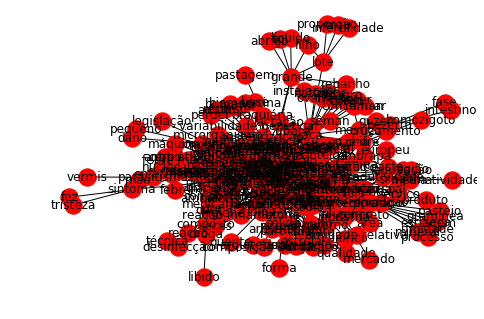

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
#%matplotlib inline
def toNetworkx(graph):
    G = nx.Graph()
    for node in graph:
        for edge in graph[node]['edges']:
            if edge['weight']!=0:
                G.add_edge(node, edge['term'])
    return G
G = toNetworkx(activeGraph(g2))
nx.draw(G, with_labels=True)
plt.draw()
plt.show()

In [11]:
perguntas = pd.read_csv('data/Raw/quinhentas_perguntas.csv')
hits = 0
recall = 0
for idx, row in perguntas.iterrows():
    grp = copy.deepcopy(graph)
    hits += isHit(grp, row['pergunta'], idx+1, audit=True)
    recall += isCorrectAnswerInWindow(grp, row['pergunta'], idx+1)

print("Precision:",str(hits/500),"Recall:",str(recall/500))

NameError: name 'graph' is not defined

In [54]:
results.to_csv('data/Networks/UpdatedResults.csv')

AttributeError: 'list' object has no attribute 'to_csv'

In [42]:
df = pd.DataFrame()
for result in results:
    df = df.append(result.get())
    #print(result.get())
df.sort_values(by=['Pct Hits', 'PctHitsInWindow'], ascending=False)
#df.to_csv('data/Networks/ResultsAt1Decay.csv')

AttributeError: 'str' object has no attribute 'get'

In [10]:
pickle_in = open(filedir+'FinalWithWHWordsWithDicioNR.pickle',"rb")
graph = pickle.load(pickle_in)
dictionary = getTermDictionary(graph)
perguntas = pd.read_csv('data/Raw/quinhentas_perguntas.csv')
#graph
#perguntas.iloc[9]['pergunta']
#activeGraph(addDocument(graph, 10, perguntas.iloc[9]['pergunta'],1,1))
#print(perguntas.iloc[9]['pergunta'])
#print([lemmatizer(w.orth_, w.pos_)[0] for w in nlp(perguntas.iloc[9]['pergunta']) if w.orth_ in dictionary or lemmatizer(w.orth_,w.pos_)[0] in dictionary])
#addDocument(graph, 10, perguntas.iloc[9]['pergunta'],1,1)
print(perguntas.iloc[0]['pergunta'])
print(listOfWords(graph, perguntas.iloc[0]['pergunta']))
print(getMostRanked(graph, perguntas.iloc[0]['pergunta']))
print(activeGraphNoDocuments(processSent(graph,perguntas.iloc[0]['pergunta'])))
print("---##---##---")
#print([w for w in activeGraph(processSent(graph, dictionary,respostas.iloc[9]['resposta'], decay=0.2))])
#print(respostas.iloc[25]['resposta'])
#print(getMostRanked(graph, dictionary,perguntas.iloc[1]['pergunta']))
#print([w for w in activeGraph(processSent(graph, dictionary,respostas.iloc[1]['resposta'], decay=0.2))])
print(97, perguntas.iloc[96]['pergunta'])
print(listOfWords(graph, perguntas.iloc[96]['pergunta']))
print(activeGraphNoDocuments(processSent(graph,perguntas.iloc[96]['pergunta'])))
print("---##---##---")
print(236, perguntas.iloc[235]['pergunta'])
print(listOfWords(graph, perguntas.iloc[235]['pergunta']))
print(activeGraphNoDocuments(processSent(graph,perguntas.iloc[96]['pergunta'])))

NameError: name 'filedir' is not defined

In [24]:
bot = textacy.keyterms.sgrank(mydoc, ngrams=(1, 2), normalize='lower', n_keyterms=0.1)
print(bot)

[('bezerro', 0.16750123167080277), ('colostro', 0.04384865210725421), ('leite', 0.04080235740290798), ('médio diário', 0.034097991926216105), ('parto', 0.030566949192413918), ('vida', 0.0255030171696117), ('proteína bruta', 0.02429998213213542), ('vaca', 0.02400132476533596), ('ganho médio', 0.023741473445999778), ('aleitamento natural', 0.0234104211591537), ('alimentação', 0.023036405590167286), ('x', 0.022920533786287993), ('fase', 0.021662345691711535), ('peso', 0.019277704400271444), ('volumoso', 0.017490856557116595), ('gestação', 0.014510453813418252), ('seco', 0.014402071150719474), ('pb', 0.013254944830854794), ('produção', 0.013131644921848202), ('maí', 0.011709575776596766), ('ndt', 0.01117470272955316), ('proteína', 0.01104071721540383), ('semana', 0.010954458097045344), ('nascimento', 0.010836221152289865), ('cuidado', 0.010754079804076697), ('lactação', 0.010635002353869853), ('ração', 0.01005357785479305), ('qualidade', 0.009600150427604398), ('base', 0.00917110451291848)